# Example: Calculating out-of-sample Markov Model Performance
In this example, we evaluate the out-of-sample performance of the daily growth rate model we developed in the previous example. 

> __Learning Objectives:__
>
> By the end of this example, you will be able to:
> * __Generate encoded state sequences from Hidden Markov Models:__ Sample discrete state trajectories from trained HMM instances using stationary distributions as initial conditions, and track jump events in Hidden Markov Models with jumps.
> * __Decode Hidden Markov Model predictions into growth rates:__ Transform discrete HMM states into continuous values using distribution models, implement nested sampling procedures for multiple simulation paths, and construct decoded archives for statistical analysis.
> * __Evaluate out-of-sample model performance using statistical tests:__ Compare simulated and observed distributions using density plots and Kolmogorov-Smirnov tests, validate means and standard deviations using confidence intervals and chi-squared distributions, and analyze autocorrelation patterns to assess volatility clustering behavior.

Let's get started!

___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We use daily open-high-low-close (OHLC) data for firms in the [S&P 500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2025` until `11-18-2025`, along with data for exchange-traded funds and volatility products.

Load the `original_dataset::DataFrame` by calling [the `MyTestingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTestingMarketDataSet).

In [2]:
original_dataset = MyTestingMarketDataSet() |> x-> x["dataset"] # load the original dataset (testing)

Dict{String, DataFrame} with 483 entries:
  "NI"   => 220×8 DataFrame…
  "EMR"  => 220×8 DataFrame…
  "CTAS" => 220×8 DataFrame…
  "HSIC" => 220×8 DataFrame…
  "KIM"  => 220×8 DataFrame…
  "PLD"  => 220×8 DataFrame…
  "IEX"  => 220×8 DataFrame…
  "BAC"  => 220×8 DataFrame…
  "CBOE" => 220×8 DataFrame…
  "EXR"  => 220×8 DataFrame…
  "NCLH" => 220×8 DataFrame…
  "CVS"  => 220×8 DataFrame…
  "DRI"  => 220×8 DataFrame…
  "DTE"  => 220×8 DataFrame…
  "ZION" => 220×8 DataFrame…
  "AVY"  => 220×8 DataFrame…
  "EW"   => 220×8 DataFrame…
  "EA"   => 220×8 DataFrame…
  "NWSA" => 220×8 DataFrame…
  ⋮      => ⋮

Not all tickers have the maximum number of trading days due to acquisition or delisting events. Collect only tickers with the maximum number of trading days.

Compute the number of records for `AAPL` and save that value in the `maximum_number_trading_days::Int64` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow # maximum number of trading days in our dataset

220

Iterate through the data and collect only tickers with `maximum_number_trading_days` records. Save the data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # check if ticker has maximum trading days
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

In [5]:
dataset["AAPL"]

Row,volume,volume_weighted_average_price,open,close,high,low,timestamp,number_of_transactions
,Float64,Float64,Float64,Float64,Float64,Float64,DateTime,Int64
1,4.02441e7,243.081,243.36,243.36,244.18,241.89,2025-01-03T05:00:00,493786
2,4.50456e7,245.173,244.31,245.0,247.33,243.2,2025-01-06T05:00:00,493920
3,4.0856e7,242.946,242.98,242.21,245.55,241.35,2025-01-07T05:00:00,462887
4,3.76289e7,242.299,241.92,242.7,243.712,240.05,2025-01-08T05:00:00,406916
5,6.17109e7,236.606,240.01,236.85,240.16,233.0,2025-01-10T05:00:00,685976
6,4.96307e7,232.753,233.53,234.4,234.67,229.72,2025-01-13T05:00:00,561231
7,3.94353e7,233.873,234.75,233.28,236.12,232.472,2025-01-14T05:00:00,436333
8,3.9832e7,237.58,234.635,237.87,238.96,234.43,2025-01-15T05:00:00,418804
9,7.17591e7,230.496,237.35,228.26,238.01,228.03,2025-01-16T05:00:00,786112


Get a list of firms in the cleaned dataset and sort them alphabetically. Store the sorted ticker symbols in the `list_of_tickers::Array{String,1}` variable:

In [6]:
list_of_tickers = keys(dataset) |> collect |> sort; # list of tickers in our dataset

### Constants and Parameters
Define constants and parameters used in this example:

In [7]:
risk_free_rate = 0.0421; # 17-Jun-2024 10-year treasury
Δt = (1/252); # time step 1 x trading in units of years
number_of_paths = 10000; # number of potential futures should we look at
blue_color = colorant"rgb(68,152,242)";
myticker = "SPY"; # ticker symbol for the SPY ETF
number_of_states = 100; # number of states in our HMM

### Growth Rate Calculation
Compute the daily growth rate time series for all firms. Store the growth rate time series in the `all_firms_excess_return_matrix::Array{Float64,2}` variable.

In [8]:
all_firms_excess_return_matrix = log_growth_matrix(dataset, list_of_tickers, 
    Δt = Δt, risk_free_rate = risk_free_rate);

Extract the growth rate for the `ticker::String` of interest and save in the `Rᵢ::Array{Float64,1}` array. This is the observed out-of-sample data.

In [9]:
Rᵢ = findfirst(x->x==myticker, list_of_tickers) |> i-> all_firms_excess_return_matrix[:,i];

#### Load the HMM model
Load the saved Markov model and Jump Markov model from the in-sample analysis. Specify the `path_to_save_file::String` variable:

In [10]:
path_to_save_file = joinpath(_PATH_TO_DATA,"HMM-WJ-$(myticker)-N-$(number_of_states)-daily-aggregate.jld2");

Load the [`HDF5` binary file](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) using [the `load(...)` function from JLD2.jl](https://github.com/JuliaIO/JLD2.jl.git). This loads the saved data into the `saved_state_dict::Dict{String, Any}` variable.

In [11]:
saved_state_dict = load(path_to_save_file)

Dict{String, Any} with 11 entries:
  "risk_free_rate"          => 0.043
  "model"                   => MyHiddenMarkovModel([1, 2, 3, 4, 5, 6, 7, 8, 9, …
  "decode"                  => Dict{Int64, Normal}(5=>Normal{Float64}(μ=-3.3565…
  "encoded_archive_with_ju… => [33 55 … 71 21; 10 42 … 60 96; … ; 63 1 … 26 18;…
  "insampledataset"         => [-0.62754, 0.839626, 0.162992, -0.0111337, 0.257…
  "jump_model"              => MyHiddenMarkovModelWithJumps([1, 2, 3, 4, 5, 6, …
  "encoded_archive"         => [19 59 … 78 1; 42 47 … 34 22; … ; 3 53 … 87 92; …
  "number_of_states"        => 100
  "in_sample_decoded_archi… => [-0.474572 0.280764 … 0.902425 -1.1545; -2.32741…
  "stationary"              => Categorical{Float64, Vector{Float64}}(…
  "in_sample_decoded_archi… => [-1.29301 0.393427 … 1.30247 -0.665223; -0.11709…

In [12]:
number_of_states = saved_state_dict["model"].states |> length;

___

## Task 1: Compute the encoded out-of-sample model prediction
Sample the `model::MyHiddenMarkovModel` or `model::MyHiddenMarkovModelWithJumps` instance to generate encoded state sequences of discrete state values $s_{j}\in\mathcal{S}$ where each sample trajectory starts from a draw from the stationary distribution $\bar\pi$.

Access the stationary distribution $\bar\pi$ from the `saved_state_dict::Dict{String, Any}` dictionary using the `stationary::String` key. Save the stationary distribution in the `π̄::Categorical{Float64, Vector{Float64}}` variable:

In [13]:
π̄ = saved_state_dict["stationary"];

Generate the `encoded_archive::Array{Int64,2}` array, which holds `number_of_paths` discrete state trajectories each of length `number_of_steps`:

> __Syntax sugar:__ The function `(m::MyHiddenMarkovModelWithJumps)(start::Int64, steps::Int64) = _simulate(m, start, steps)` provides shortcut syntax to sample the `model::MyHiddenMarkovModelWithJumps` instance, where the sampling logic is in the `_simulate(m, start, steps)` function. A similar function exists for the `m::MyHiddenMarkovModel` type.

After specifying `number_of_paths::Int64`, `number_of_steps::Int64`, and initializing the `encoded_archive::Array{Int64,2}` array, populate the sample array using a nested [`for-loop`](https://docs.julialang.org/en/v1/manual/variables-and-scoping/#Loops-and-Comprehensions):
* The outer loop iterates over sample paths (index `i`), generating an initial state by drawing from the $\bar\pi$ distribution. Save the initial state in the `start_state::Int64` variable.
* The inner loop iterates over time steps (index `j`), generating a `number_of_steps`$\times$ `1` array of discrete state values $s\in\mathcal{S}$ in the `tmp::Array{Int64,1}` array. Add values to the `encoded_archive` array, where time steps are rows and sample paths are columns.

In [14]:
encoded_archive, jump_indicator_archive = let
    
    model = saved_state_dict["jump_model"]; # grab whichever version of the model you want
    number_of_steps = 2*length(Rᵢ); # we'll generate paths twice as long as the original data
    encoded_archive = Array{Int64,2}(undef, number_of_steps, number_of_paths);
    jump_indicator_archive = Array{Int64,2}(undef, number_of_steps, number_of_paths);
    
    for i ∈ 1:number_of_paths
        start_state = rand(π̄);
        tmp = model(start_state, number_of_steps) # generates state sequence of length number_of_steps
        for j ∈ 1:number_of_steps
            encoded_archive[j,i] = tmp[j,1]
            jump_indicator_archive[j,i] = tmp[j,2]
        end
    end
    encoded_archive, jump_indicator_archive
end

([64 37 … 72 58; 53 80 … 94 46; … ; 50 42 … 63 95; 61 17 … 18 14], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0])

In [15]:
encoded_archive

438×10000 Matrix{Int64}:
 64  37  64  28  23  83  56   9  100  …  93  17  83  90   9  73  25  72  58
 53  80  17  78  87  51  60   6   82     84  80  70  99  19  94   6  94  46
 76  56  80   2   2  25  63  36   54     84  24  68  96  17   4  80  83  99
 83  97  52  17   2  46  95  31   26     63  68  69  65  41   6  36  89  37
 80  40  91  91  98  75  47  29   79     71  61  79  40  62  80  64  48  17
 56  51  28  74  50  38  49  91   12  …  29  79  29  10  15  30  68  42  30
 42  42  40  71  15  34  86  80   24     10  38  36   1   7  68  76  66  78
 17  17  57  20  14  28  56  67   27      8  23  63   6  14   8   8  41  52
 16  51  76   7  17  77  81  29   37      6  30  24  90  61  45   5  31  27
 85  97  73   9  65  98  93  47   80     90  21  81  22  13  75   8  33  40
  ⋮                   ⋮               ⋱                   ⋮              
 27  66  96  91   6  66  29  45   83     87  89  50  80  46  95  89  20  46
 41  73  73  80  42   9  28  60    6  …   6  61  55  66  46  56  

__How many jumps?__ The `jump_indicator_archive::Array{Int64,2}` array holds jump indicators for each time step and sample path. A value of `1` indicates a jump, while `0` indicates no jump.

In [16]:
jump_trial_index_set = let
    
    number_of_steps = 2*length(Rᵢ);
    has_jumps_flag = any(x->x==1, jump_indicator_archive);
    jump_trial_index_set = Set{Int64}();
    if (has_jumps_flag == false)
        println("No jumps were detected in the simulated paths.")
    end;

    for i ∈ 1:number_of_paths
        for j ∈ 1:number_of_steps
            if (jump_indicator_archive[j,i] == 1)
                push!(jump_trial_index_set, i);
            end
        end
    end
    println("Number of paths with at least one jump event: $(length(jump_trial_index_set)) out of $number_of_paths total paths.")

    jump_trial_index_set; # return the trial index set
end;

Number of paths with at least one jump event: 459 out of 10000 total paths.


___

## Task 2: Decode the out-of-sample model prediction
Convert the discrete states in the `encoded_archive::Array{Int64,2}` array into excess growth rate values using a decoding model.

Load the decode model from the `saved_state_dict::Dict{String, Any}` dictionary using the `decode::String` key. Save the decode model in the `decode_distribution_model::Dict{Int64, Normal}` dictionary.

In [17]:
decode_distribution_model = saved_state_dict["decode"];

The `decode_distribution_model::Dict{Int64, Normal}` dictionary holds a [Normal distribution model](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal) for each state $s\in\mathcal{S}$. Sample these distributions to generate excess growth rate values corresponding to discrete states. Iterate through the `encoded_archive` array and sample the decode model associated with $s\in\mathcal{S}$, then save values in the `out_of_sample_decoded_archive::Array{Float64,2}` array using a nested [`for-loop`](https://docs.julialang.org/en/v1/manual/variables-and-scoping/#Loops-and-Comprehensions):

> The outer loop iterates over sample paths (index `i`), while the inner loop iterates over time steps (index `j`). Inside the inner loop, select state `s`, access the corresponding Normal decode model for state `s` (the `j,i` element of `encoded_archive`), and sample that model [using `rand(...)` from Distributions.jl](https://juliastats.org/Distributions.jl/stable/univariate/#Base.rand-Tuple{AbstractRNG,%20UnivariateDistribution}) with the [Julia pipe `|>` operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping).

The `out_of_sample_decoded_archive::Array{Float64,2}` holds excess growth rate values for each time step and sample path.

In [18]:
out_of_sample_decoded_archive = let

    # initialize -
    bottom_states = [1,2,3,4,5]; # super bad
    top_states = [number_of_states-4, number_of_states-3, number_of_states-2, number_of_states-1, number_of_states];
    extremestates = vcat(bottom_states, top_states);
    extremestateset = Set{Int64}();
    for s ∈ extremestates
        push!(extremestateset, s);
    end



    number_of_steps = 2*length(Rᵢ);
    out_of_sample_decoded_archive = Array{Float64,2}(undef, number_of_steps, number_of_paths);
    
    for i ∈ 1:number_of_paths
        for j ∈ 1:number_of_steps
            s = encoded_archive[j,i];
            d = decode_distribution_model[s];
            out_of_sample_decoded_archive[j,i] = rand(d);
        end
    end
    out_of_sample_decoded_archive; # actual excess growth value (not internal state variables)
end

438×10000 Matrix{Float64}:
  0.593625   -0.320757    0.599757   …  -0.916409    0.949311    0.369833
  0.21573     1.442      -1.47127       -3.05345     3.18863     0.00781074
  1.20398     0.316579    1.43813        1.45269     1.63186     5.22701
  1.68368     3.98221     0.177483      -0.372487    2.27994    -0.298836
  1.43084    -0.186826    2.57648        0.601832    0.0446521  -1.45337
  0.325621    0.154548   -0.725867   …   0.760435   -0.125416   -0.631167
 -0.12482    -0.136828   -0.208072       1.19567     0.685576    1.27487
 -1.42769    -1.46113     0.34337       -2.61148    -0.173216    0.171669
 -1.56005     0.155906    1.17687       -3.41498    -0.593607   -0.777622
  1.78658     4.05851     1.02121       -2.68572    -0.481218   -0.203766
  ⋮                                  ⋱                          
 -0.795753    0.667654    3.65702        2.27666    -1.23153     0.00484931
 -0.143162    0.995523    1.02636    …   0.0956876   1.32324     1.53147
  0.558037    1.1098

___

## Task 3: How good is the out-of-sample model prediction?
Test how well the out-of-sample simulations in the `out_of_sample_decoded_archive::Array{Float64,2}` array replicate the properties of the out-of-sample observations.

First, plot the simulated distributions versus the observed out-of-sample excess growth distributions.

Then, [use `ApproximateTwoSampleKSTest` from HypothesisTests.jl](https://github.com/JuliaStats/HypothesisTests.jl) to compute the fraction of trials drawn from the same distribution.

Unhide the code block below to see the observed and simulated excess annual growth rate distribution for the out-of-sample data.

> __Summary__: The simulated out-of-sample excess growth rate distributions (blue lines) and the observed distribution (red line) are qualitatively similar. The simulated distributions appear more heavily tailed, with more density for near-zero growth rates and broader tails.

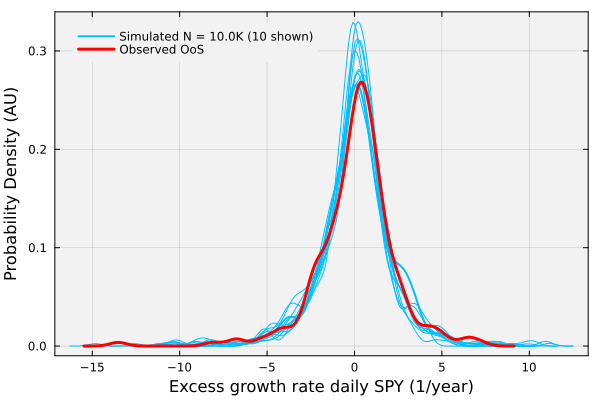

In [19]:
let
    q = plot(); 
    skip = 1000;
    N = 1:skip:number_of_paths |> collect |> length;
    density!(out_of_sample_decoded_archive[:,1], lw=2, c=:deepskyblue1, label="Simulated N = $(number_of_paths/1000)K ($(N) shown)", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topleft)
    for i ∈ 2:skip:number_of_paths
        density!(out_of_sample_decoded_archive[:,i], lw=1, c=:deepskyblue1, label="")
    end
    density!(Rᵢ, c=:red, lw=3, label="Observed OoS")
    xlabel!("Excess growth rate daily $(myticker) (1/year)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
    current()
end

### Check: Mean and standard deviation of the out-of-sample data
Check if the simulated values bound the observed mean and standard deviation for the out-of-sample data.

#### Simulated mean and standard deviation
Compute the mean over the time dimension (rows) of the `out_of_sample_decoded_archive` array using [the `mean(...)` function with `dim = 1`](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean).

This returns `number_of_paths` values for the mean (one per sample path). Compute the mean over sample paths [using `mean(...)` again](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean) with the [Julia pipe `|>` operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). Save the simulated sample mean as the `μ̄::Float64` variable:

In [20]:
μ̄ = mean(out_of_sample_decoded_archive, dims=1) |> x -> mean(x); # average mean
println("Out-of-sample estimated simulated mean: μ̄ = $(μ̄)")

Out-of-sample estimated simulated mean: μ̄ = 0.06207616729900026


Compute the standard deviation over time and then over the `number_of_paths` sample paths using [the `std(...)` function with `dim = 1`](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.std) with [the `mean(...)` function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean) and the [Julia pipe `|>` operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). Save the simulated sample standard deviation as the `σ̄::Float64` variable:

In [21]:
σ̄ = std(out_of_sample_decoded_archive, dims=1) |> x -> mean(x); # average standard deviation
println("Out-of-sample estimated simulated standard deviation: σ̄ = $(σ̄)")

Out-of-sample estimated simulated standard deviation: σ̄ = 2.165763179672727


#### Comparison with observed values
Compute the observed mean and standard deviation from the out-of-sample data using [`mean(...)`](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean) and [`std(...)`](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean). Save these values in the `μ::Float64` and `σ::Float64` variables:

In [22]:
μ = mean(Rᵢ, dims=1) |> first; # observed growth rate from data
σ = std(Rᵢ, dims=1) |> first; # observed standard deviation from data

__Test I__: Test whether the observed out-of-sample excess growth rate mean is contained in a $\pm$ `SEM` range around the mean computed over simulation samples: 
$$
\mu \in R_{\mu} \equiv \left[\bar{\mu}-z_{\alpha/2}\frac{\bar{\sigma}}{\sqrt{N}},\,\bar{\mu}+z_{\alpha/2}\frac{\bar{\sigma}}{\sqrt{N}}\right]
$$
using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert). If $\mu\notin{R}_{\mu}$, i.e., the observed mean is not bounded by $\pm$`SEM`, then an [AssertionError is thrown](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError), where `SEM` denotes the [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error).

In [23]:
let
    z = 1.96; # 95% confidence
    R = (μ̄ - z*σ̄/√number_of_paths, μ̄ + z*σ̄/√number_of_paths);
    println("R = $(R) and μ = $(μ), μ̄ = $(μ̄)")
    @assert R[1] ≤ μ && μ ≤ R[2]
end

R = (0.019627208977414802, 0.10452512562058572) and μ = 0.08860106000469448, μ̄ = 0.06207616729900026


In [24]:
let
    ϵ = 100*abs(((μ - μ̄)/μ)); # percentage difference in mean
    println("The percentage difference between the observed and simulated mean is: $(ϵ)%")
end

The percentage difference between the observed and simulated mean is: 29.93744398124448%


__Test II__: Test the simulated versus observed standard deviation of the excess growth for the out-of-sample values:
$$
\sigma\in R_{\sigma} \equiv \left[\sqrt\frac{(N-1)\cdot\bar{\sigma}^2}{\chi_{r}^2},\,\sqrt{\frac{(N-1)\cdot\bar{\sigma}^2}{\chi_{l}^2}}\,\right]
$$
using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert). If $\sigma\notin{R}_{\sigma}$, i.e., the observed standard deviation is not bounded by $\pm\sqrt{(N-1)\cdot{\bar{\sigma}^{2}}/\chi_{\star}^{2}}$, then an [AssertionError is thrown](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError). 

Where $\chi_{\star}^{2}$ denotes the $\star=\left\{l,r\right\}$ left (`l`) or right (`r`) tail of the [chi-squared distribution with $N − 1$ degrees of freedom](https://en.wikipedia.org/wiki/Chi-squared_distribution). Use [the `Chisq(...)` distribution from Distributions.jl](https://github.com/JuliaStats/Distributions.jl) with [the `quantile(...)` function](https://juliastats.org/Distributions.jl/stable/univariate/#Statistics.quantile-Tuple{UnivariateDistribution,%20Real}) to compute $\chi_{\star}^{2}$ values:

In [25]:
α = 0.99;
ᾱ = (1 - α);
chi_d = Chisq(number_of_paths - 1);
χₗ = quantile(chi_d,ᾱ);
χᵣ = quantile(chi_d,α);
println("For CI = $(100*α)%, the (χₗ,χᵣ) = ($(χₗ),$(χᵣ))")

For CI = 99.0%, the (χₗ,χᵣ) = (9672.965289892134,10330.917127604109)


Finally, check if $\sigma\in{R}_{\sigma}$ using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert):

In [26]:
let
    R = (sqrt(((number_of_paths - 1)*σ̄^2)/(χᵣ)), sqrt(((number_of_paths - 1)*σ̄^2)/(χₗ)));
    println("R = $(R) at CI = $(100*α)% and σ = $(σ), σ̄ = $(σ̄)")
    @assert R[1] ≤ σ && σ ≤ R[2]
end

R = (2.1306877612528616, 2.2019600506751593) at CI = 99.0% and σ = 2.30508724559402, σ̄ = 2.165763179672727


AssertionError: AssertionError: R[1] ≤ σ && σ ≤ R[2]

__What if we fail Test II?__ The model simulation may fail `Test II`, meaning the uncertainty of the standard deviation computed by the Markov model does not include the standard deviation value from the out-of-sample observations (the simulated range is biased high). The standard deviation values have a percentage difference of:

In [27]:
let
    ϵ = 100*abs(((σ - σ̄)/σ)); # percentage difference in std
    println("The percentage difference between the observed and simulated stdev is: $(ϵ)%")
end

The percentage difference between the observed and simulated stdev is: 6.044199246149979%


### Check: Are the predicted and observed out-of-sample distributions the same?
If the Markov model is correct, the observed excess growth rate distribution and the model-calculated distribution should be drawn from the same distribution. Check this hypothesis using [ApproximateTwoSampleKSTest from HypothesisTests.jl](https://github.com/JuliaStats/HypothesisTests.jl).

> __Test:__ `H0:null hypothesis` is that `x` and `y` are drawn from the same distribution against the `H1:alternative hypothesis` that `x` and `y` come from different distributions.

Perform the test on each of the `number_of_paths` sample trajectories and compute an overall score. If `pvalue > pvalue_cutoff`, then fail to reject `H0:null hypothesis`, meaning `x` and `y` appear drawn from the same distribution.

In [28]:
let
    pvalue_cutoff = 0.05; # if larger than this, we reject the H0
    pass_counter = 0;
    for i ∈ 1:number_of_paths
        test_value = ApproximateTwoSampleKSTest(Rᵢ, out_of_sample_decoded_archive[:,i]) |> pvalue   
        if (test_value > pvalue_cutoff)
            pass_counter += 1 # we pass (fail to reject) x and y are from the same distribution
        end
    end
    println("Pass percentage: $((pass_counter/number_of_paths)*100)%")
end

Pass percentage: 98.45%


In [29]:
ApproximateTwoSampleKSTest(Rᵢ, out_of_sample_decoded_archive[:,rand(1:number_of_paths)])

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.0890411

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.1973

Details:
    number of observations:   [219,438]
    KS-statistic:              1.0758876551830783


In [30]:
index_to_plot = rand(jump_trial_index_set); # generate a random index from the jump set

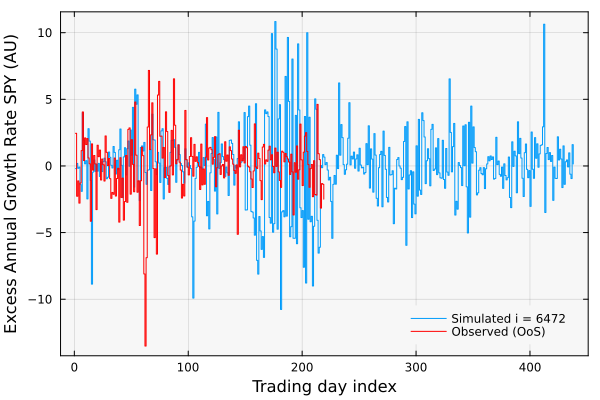

In [31]:
let
    number_of_steps = length(dataset); # number of tickers in dataset

    plot(out_of_sample_decoded_archive[:,index_to_plot], linetype=:steppost, label="Simulated i = $(index_to_plot)", 
        bg="gray97", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(Rᵢ, linetype=:steppost, c=:red, label="Observed (OoS)")
    xlabel!("Trading day index", fontsize=18)
    ylabel!("Excess Annual Growth Rate $(myticker) (AU)", fontsize=18)
end

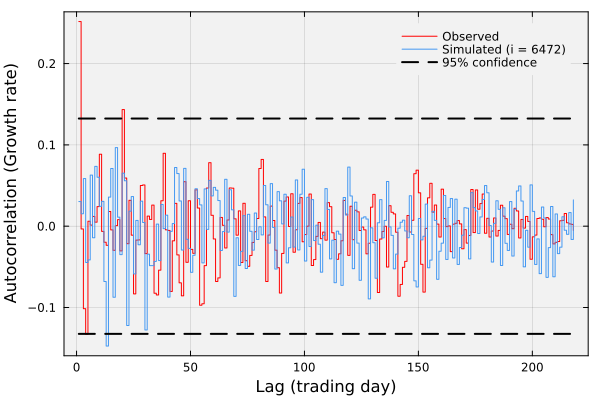

In [32]:
let
    # generate (or get) a random index -
    random_index = index_to_plot; # select a random path with at least one jump
    number_of_steps = length(Rᵢ);
    X = Rᵢ;

    plot(autocor(X, (1:(number_of_steps-1) |> collect)), label="Observed", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, linetype=:steppost)
    plot!(autocor((out_of_sample_decoded_archive[:,random_index]), ((1:(number_of_steps - 1)) |> collect)), c=blue_color,
        label="Simulated (i = $(random_index))", linetype=:steppost)
    
    LINE = (1.96/sqrt(number_of_steps))*ones(number_of_steps-1);
    plot!(LINE, label="95% confidence", lw=2, c=:black, ls=:dash)
    plot!(-LINE, label="", lw=2, c=:black, ls=:dash)
    xlabel!("Lag (trading day)", fontsize=18)
    ylabel!("Autocorrelation (Growth rate)", fontsize=18)
end

Examine the __volatility clustering__ behavior of the out-of-sample data versus a sample trajectory from the model.

> Volatility clustering is a phenomenon in financial time series where large changes in asset prices tend to be followed by large changes (of either sign), and small changes tend to be followed by small changes. This phenomenon can be observed by examining the autocorrelation function of the absolute value of the excess growth rate time series.

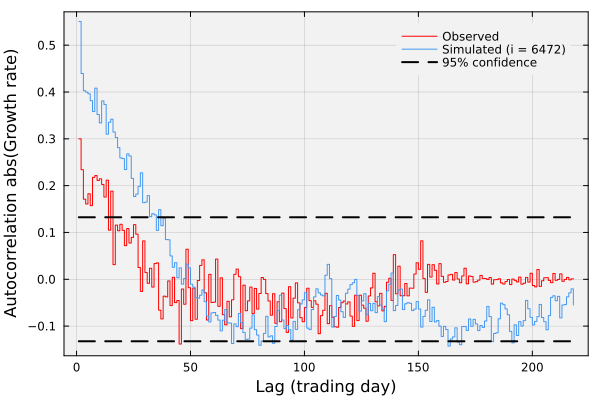

In [33]:
let
    # generate (or get) a random index -
    random_index = index_to_plot; # select a random path with at least one jump
    number_of_steps = length(Rᵢ);
    X = abs.(Rᵢ);

    plot(autocor(X, (1:(number_of_steps-1) |> collect)), label="Observed", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, linetype=:steppost, lw = 1)
    plot!(autocor(abs.(out_of_sample_decoded_archive[:,random_index]), ((1:(number_of_steps - 1)) |> collect)), c=blue_color,
        label="Simulated (i = $(random_index))", linetype=:steppost, lw = 1)
    
    LINE = (1.96/sqrt(number_of_steps))*ones(number_of_steps-1);
    plot!(LINE, label="95% confidence", lw=2, c=:black, ls=:dash)
    plot!(-LINE, label="", lw=2, c=:black, ls=:dash)
    xlabel!("Lag (trading day)", fontsize=18)
    ylabel!("Autocorrelation abs(Growth rate)", fontsize=18)
end

___

## Summary
This example demonstrates how to evaluate the out-of-sample performance of Hidden Markov Models for predicting stock market growth rates.

> __Key Takeaways:__
>
> * __Encoded state sequences provide the foundation for HMM predictions:__ Sampling from trained Hidden Markov Models generates discrete state trajectories that capture the model's learned dynamics. Jump indicators track discrete regime changes across simulation paths.
> * __Decoding transforms discrete states into continuous predictions:__ Normal distribution models associated with each HMM state convert encoded trajectories into growth rate predictions. Multiple simulation paths enable statistical analysis of model uncertainty.
> * __Statistical tests quantify out-of-sample model performance:__ Confidence interval tests for means and standard deviations reveal whether simulated values bound observations. Kolmogorov-Smirnov tests assess distributional similarity between predictions and observations, while autocorrelation analysis evaluates volatility clustering patterns.

Hidden Markov Models provide a framework for generating probabilistic forecasts with quantifiable uncertainty.
___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.